# Train car - v4

```
data ; crop and resize  
network ; xception , decrease batch_size. 

ImageAugment  ; shift add. 
random_eraser ; image part remove

batch 32
earlystop ; f1_score 
checkpoint best save 

train acc;  , val acc;  , lb acc;   
model1 ;  96, 84
model2;  96, 85
model3 ; 95, 86

enssamble. sum.


```


## load package

In [1]:
import sys
import pandas as pd

from keras.applications import xception
from keras.preprocessing import image
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

Using TensorFlow backend.


In [18]:
cache=False
basedir = './'
imgwidth=224
imgheight=224
get_ipython().run_line_magic('matplotlib', 'inline')

# K fold
fold_k = 5
# current fold
fold_c = 4   # 1~fold_k

## TRAIN

In [19]:
x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [20]:
# cross validation
datacnt = x_trainall.shape[0]
flagval = np.zeros(datacnt)
modelpath = 'car-v4-'+str(fold_c)+'.ckpt'

print('modelpath=', modelpath)
flagval[(fold_c-1)*2000:(fold_c)*2000] = 1

x_train = x_trainall[flagval==0]
y_train = y_trainall[flagval==0]
x_val = x_trainall[flagval==1]
y_val = y_trainall[flagval==1]
    
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))

modelpath= car-v4-4.ckpt
(7990, 224, 224, 3) (7990,) (2000, 224, 224, 3) (2000,)
0 195


In [21]:
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

In [22]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [23]:
# Image Augumentation
batch_size=32  # 32, 64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=False, 
                              width_shift_range=0.1, height_shift_range=0.1,
                              fill_mode='nearest', preprocessing_function = get_random_eraser(v_l=0, v_h=1),)
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=False)

In [24]:
# f1 score 
def new_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [25]:
### checkpoint save weights in progress...
cp_callback = ModelCheckpoint(modelpath,  monitor='val_new_score', mode='max', save_best_only=True, save_weights_only=True)
es_callback = EarlyStopping(monitor='val_new_score',  mode='max', patience=20, min_delta=0.0001)

# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [26]:
inputs = Input(shape=(224,224,3))
net = xception.Xception(input_tensor=inputs, input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='max')
net2 = Dense(224, activation='relu') (net.layers[-1].output)
net2 = Dense(196)(net2)
net2 = Softmax(196)(net2)
model = Model(inputs=inputs, outputs=net2)
# model.summary()

In [27]:
##### model freeze. after acc 90.
if False:
    print('freezing...')
    for layer in model.layers[:-4]:
        layer.trainable=False
else:
    print('no freezing...')
#     for layer in model.layers:
#         print(layer, layer.trainable)
#     model.summary()

no freezing...


In [28]:
if os.path.exists(modelpath):
    print('load weights...')
    model.load_weights(modelpath)
else:
    print('not found weights... new')

not found weights... new


In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', new_score])

In [30]:
# epochs = 100
hist = model.fit_generator( train_generator, initial_epoch=0, epochs = 500, validation_data=val_generator, 
                           callbacks=[tensorboard, cp_callback, es_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
 14/249 [>.............................] - ETA: 3:00 - loss: 5.3591 - acc: 0.0000e+00 - new_score: 6.2500e-09

KeyboardInterrupt: 

In [20]:
# hist = model.evaluate( x_val/255., y_val_onehot, batch_size=30, verbose=1 )
hist = model.evaluate_generator(val_generator, steps=len(x_val)/batch_size)
print(hist)

[0.7484233678579331, 0.846, 0.8513013396263123]


In [21]:
model.save('car-v4.h5')

### Submission

In [3]:
# test data load for submission
x_test = np.load('x_test.npy')
x_test = x_test/255.

In [31]:
# one model submission 
if False:
    predictions = model.predict( x_test )
    pdi = np.argmax(predictions, axis=1)
    print(pdi, np.min(pdi), np.max(pdi))

In [6]:
# ensamble. submission.
# model = load_mode('car-v4.h5')
if True:
#     mo = load_model(mp, custom_objects={'new_score': new_score})
    inputs = Input(shape=(224,224,3))
    net = xception.Xception(input_tensor=inputs, input_shape=(224, 224, 3), include_top=False, pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)
    model = Model(inputs=inputs, outputs=net2)
    predictions=[]
    for ff in range(1, fold_k+1):
        mp='car-v4-'+str(ff)+'.ckpt'
        print('model',ff,':', mp)
        model.load_weights(mp)
        pr = model.predict( x_test )
        predictions.append(pr)
        print('prediction',ff,':',pr)
    predictions = np.asarray(predictions)
    prk = np.sum(predictions, axis=0 )
    pdi = np.argmax(prk, axis=1)
    print('final:', pdi, np.min(pdi), np.max(pdi))

model1: [[3.69458289e-14 1.11258962e-35 1.77841311e-30 ... 2.23007878e-13
  1.40615340e-23 1.00434986e-23]
 [1.16716154e-20 3.41513017e-16 4.37719437e-15 ... 3.59256451e-18
  5.38302753e-14 2.45638759e-10]
 [1.83429156e-23 4.70149961e-23 1.99139752e-19 ... 1.70155275e-27
  7.28396137e-24 1.46811952e-17]
 ...
 [2.84027674e-27 2.25980703e-19 1.54869200e-19 ... 3.77228287e-20
  6.34357586e-16 3.66114781e-28]
 [2.74565703e-16 3.95558224e-18 1.68523005e-18 ... 7.69631783e-20
  1.92088345e-09 1.56790845e-12]
 [2.12169606e-22 1.42689730e-15 6.09978214e-12 ... 5.84064686e-24
  1.16103016e-09 1.41565775e-23]]
model2: [[3.43239437e-09 3.34558650e-36 7.07518992e-26 ... 6.44292454e-13
  4.49355019e-23 7.84796395e-20]
 [9.17424760e-17 1.76205610e-20 1.21798364e-18 ... 3.95197028e-25
  3.62783404e-24 1.63518965e-13]
 [7.78969576e-25 1.23197044e-29 2.47368342e-30 ... 2.27081043e-23
  6.36523828e-25 5.76079336e-16]
 ...
 [2.27793794e-28 5.88929170e-17 2.78877802e-18 ... 9.08388287e-15
  1.57846823e-17

In [7]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


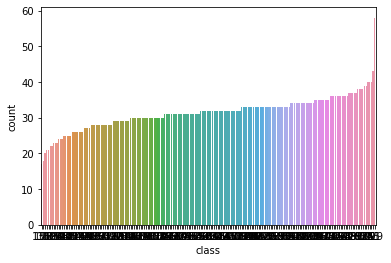

In [8]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)